In [22]:
# Example-7-MGP-BS-Pricing
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, gpytorch=0.1.0, torch=1.5.0, scipy=1.4.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F. Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Overview
The purpose of this notebook is to demonstrate the fitting of a multi-response Gaussian Process Regression model (GP) to the prices of two options. In this notebook, the prices of a call and put are generated from the Black-Scholes model.  The notebook begins by building a multi-GP model, and then evaluates the error.

Finally the notebook studies the posterior covariance term which is uniquely available in the multi-GP model. See Section 6 for further details.

In [2]:
import torch
import gpytorch
import numpy as np
from BlackScholes import bsformula
from matplotlib import pyplot as plt
from scipy import stats  

%matplotlib inline

## Black-Scholes Model

First, set the model parameters

In [4]:
r = 0.0     # risk-free rate
S= 100      # Underlying spot
KC = 110    # Call strike
KP = 90     # Put strike
sigma = 0.3 # implied volatility
T = 2.0     # Time to maturity

Define the call and put prices using the BS model


In [5]:
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

Create an input vector representing the underlying and output vectors `train_y1` and `train_y2` representing the call and put prices respectively from the Black-Scholes model. 

In [7]:
lb = 0.001             # lower bound on domain
ub = 300               # upper bound on domain
training_number = 50   # Number of training samples
testing_number =  100  # Number of testing samples

train_x = torch.linspace(0, 1.0, training_number)
train_y1 = torch.FloatTensor(call(np.array(train_x)))
train_y2 = torch.FloatTensor(put(np.array(train_x)))

Create `train_y` which stacks the two into a tensor for training a model which outputs both quantities

In [8]:
train_y = torch.stack([train_y1, train_y2], -1)

Observe the first few elements of `train_y`:

In [9]:
print('         Call        Put')
print(train_y[:5])

         Call        Put
tensor([[0.0000e+00, 8.9999e+01],
        [7.5293e-12, 8.3877e+01],
        [3.1548e-07, 7.7754e+01],
        [4.9525e-05, 7.1632e+01],
        [1.0728e-03, 6.5515e+01]])


We generate some testing data in the same way

In [10]:
test_x = torch.linspace(0, 1.0, testing_number)
test_y1 = torch.FloatTensor(call(np.array(test_x)))
test_y2 = torch.FloatTensor(put(np.array(test_x)))
test_y = torch.stack([test_y1, test_y2], -1)

## Multi-Reponse GP Model

Here we create the class which defines the architecture of our GP model

In [11]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)), num_tasks=2, rank=1
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

## Fit the multi-GP model

In [12]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 300
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.lengthscale, likelihood.noise))
    
    optimizer.step()

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Iter 1/300 - Loss: 285.641 lengthscale: 0.693 noise: 0.693
Iter 2/300 - Loss: 229.659 lengthscale: 0.644 noise: 0.744
Iter 3/300 - Loss: 184.783 lengthscale: 0.599 noise: 0.797
Iter 4/300 - Loss: 149.499 lengthscale: 0.556 noise: 0.850
Iter 5/300 - Loss: 122.151 lengthscale: 0.518 noise: 0.904
Iter 6/300 - Loss: 101.130 lengthscale: 0.483 noise: 0.956
Iter 7/300 - Loss: 85.003 lengthscale: 0.451 noise: 1.008
Iter 8/300 - Loss: 72.588 lengthscale: 0.423 noise: 1.059
Iter 9/300 - Loss: 62.956 lengthscale: 0.399 noise: 1.108
Iter 10/300 - Loss: 55.406 lengthscale: 0.377 noise: 1.156
Iter 11/300 - Loss: 49.417 lengthscale: 0.357 noise: 1.201
Iter 12/300 - Loss: 44.607 lengthscale: 0.340 noise: 1.245
Iter 13/300 - Loss: 40.697 lengthscale: 0.324 noise: 1.287
Iter 14/300 - Loss: 37.478 lengthscale: 0.310 noise: 1.328
Iter 15/300 - Loss: 34.798 lengthscale: 0.298 noise: 1.366
Iter 16/300 - Loss: 32.541 lengthscale: 0.287 noise: 1.402
Iter 17/300 - Loss: 30.620 lengthscale: 0.277 noise: 1.437


Use the fitted model to predict the call and put values of the test set

In [13]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat = likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

Print the fitted parameters

In [14]:
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
lengthscale = model.covar_module.data_covar_module.base_kernel.lengthscale
sigma_2_n = likelihood.noise
nu = model.covar_module.data_covar_module.base_kernel.nu
print(lengthscale, sigma_2_n, nu, Omega, sep='\n')

tensor([[0.1999]], grad_fn=<SoftplusBackward0>)
tensor([2.1257], grad_fn=<AddBackward0>)
2.5
[[31.174578  -2.0760832]
 [-2.0760832  4.204429 ]]


Plot the predictions of the model, with variance bands

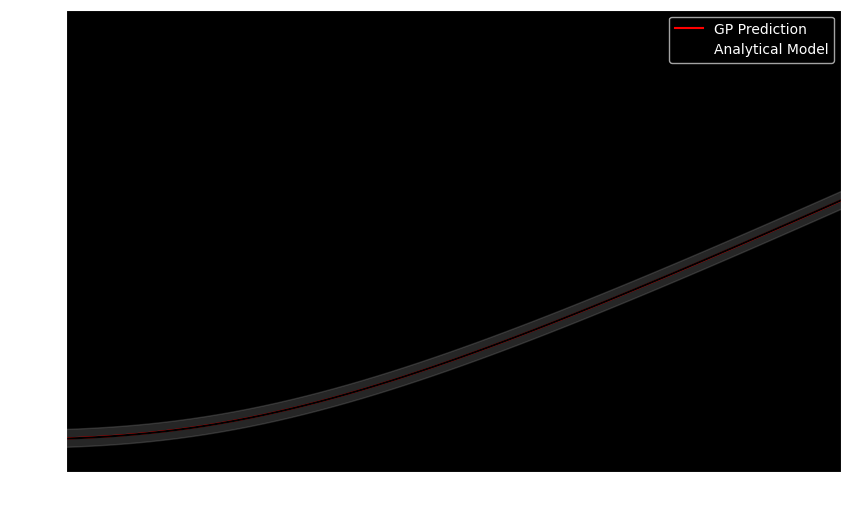

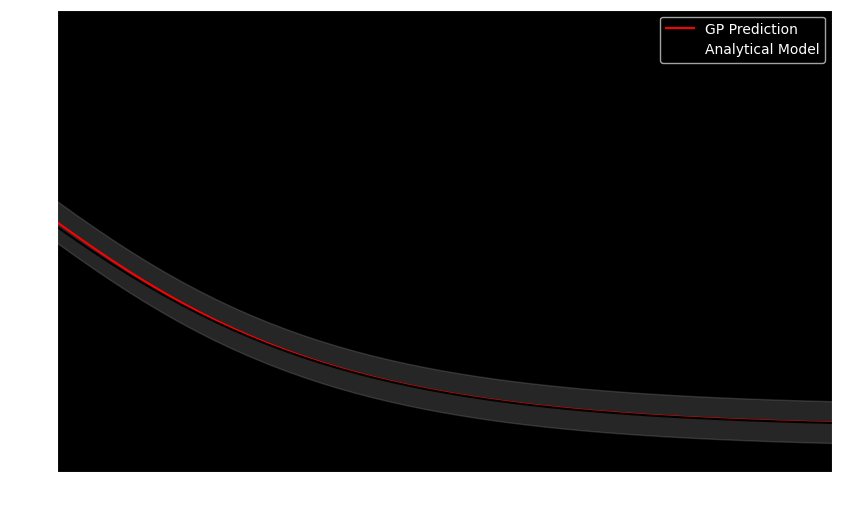

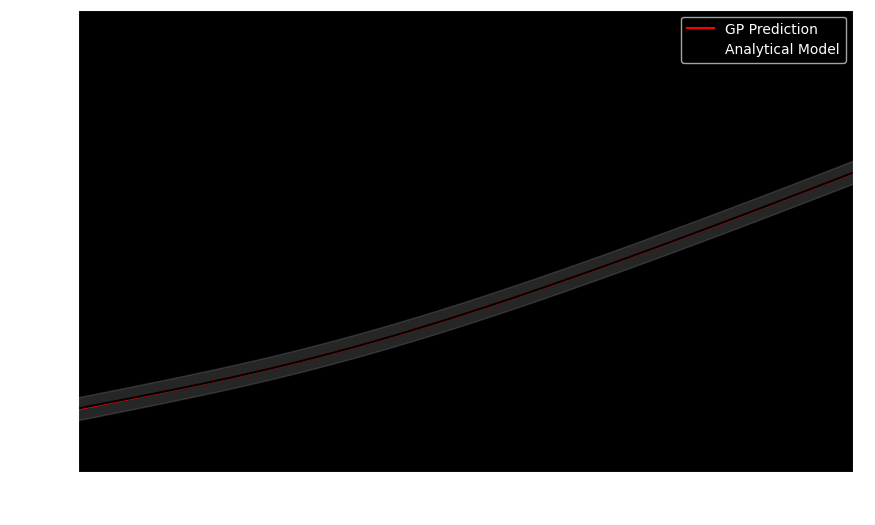

In [15]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,0]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,0]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,0], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,0].detach().numpy(), upper[:,0].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,1]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,1], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,1].detach().numpy(), upper[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KP])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*np.array(y_hat.mean[:,0])- np.array(y_hat.mean[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*np.array(test_y[:,0])-np.array(test_y[:,1]) , color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, 2*train_y[:,0]-train_y[:,1], color = 'black', marker = '+', s = 100) 

plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*lower[:,0].detach().numpy()-upper[:,1].detach().numpy() , 2.0*upper[:,0].detach().numpy()-lower[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('$\pi$');

## Evaluate the covariance of the posterior

In [15]:
var_1 = np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),0)[0:199:2]
var_2 = np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),0)[1:199:2]
covar_12 = np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),1)[0:199:2]

/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


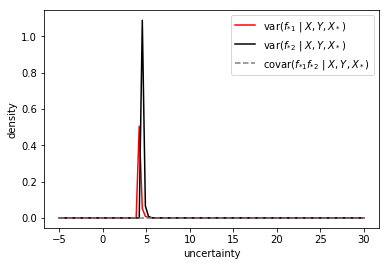

In [16]:
lnspc = np.linspace(-5.0, 30, 100)

ab,bb,cb,db = stats.beta.fit(var_1)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb, cb, db)  
plt.plot(lnspc, pdf_beta, label='var($f_{*1}$ $\|$ $X,Y,X_*$)', color='r')

ab,bb,cb,db = stats.beta.fit(var_2)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb, cb, db)  
plt.plot(lnspc, pdf_beta, label='var($f_{*2}$ $\|$ $X,Y,X_*$)', color='k')

ab,bb,cb,db = stats.beta.fit(covar_12)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb, cb, db)  
plt.plot(lnspc, pdf_beta, label='covar($f_{*1}f_{*2}$ $\|$ $X,Y,X_*$)', color="grey", linestyle='--')

plt.xlabel('uncertainty')
plt.ylabel('density')
plt.legend()
plt.show()